In [1]:
import os
import cv2
import laspy as lp
import numpy as np
import pyvista as pv 
import matplotlib.pyplot as plt

from PIL import Image
from scipy.interpolate import griddata
from numpy.polynomial.polynomial import Polynomial

In [2]:
def read_las_file(las_path: str):
    try:
        return lp.read(las_path)
    except Exception as e:
        print(f"Error reading {las_path}: {e}")
        return None

def normalize_points(points, eps= 1e-8):
    if not isinstance(points, np.ndarray) or points.shape[1] != 3:
        raise ValueError("points must be a numpy array with shape (n, 3).")
    points_ = points.copy()

    x_min, x_max = np.min(points_[:,0]), np.max(points_[:,0])
    y_min, y_max = np.min(points_[:,1]), np.max(points_[:,1])
    z_min, z_max = np.min(points_[:,2]), np.max(points_[:,2])

    points_[:,0] = (points_[:,0] - x_min) / (x_max - x_min + eps)
    points_[:,1] = (points_[:,1] - y_min) / (y_max - y_min + eps)
    points_[:,2] = (points_[:,2] - z_min) / (z_max - z_min + eps)
    
    return points_, x_min, x_max, y_min, y_max, z_min, z_max  
   
def normalize_colors(colors):
    rgba = colors - colors.min(axis=0)
    rgba = rgba / rgba.max(axis=0)
    return rgba #(rgba * 255).astype(np.uint8)

In [3]:
import numpy as np
from scipy.spatial import KDTree

def remove_low_density_points(points, radius=0.1, min_neighbors=3):
    tree = KDTree(points)
    distances, _ = tree.query(points, k=min_neighbors, distance_upper_bound=radius)
    mask = np.all(distances < radius, axis=1)
    return mask #(N,3)

def remove_low_intensity_points(points):
    intensity_mean, intensity_std = np.mean(points), np.std(points)
    lower_threshold = intensity_mean - 2 * intensity_std
    upper_threshold = intensity_mean + 2 * intensity_std
    mask = (points > lower_threshold) & (points < upper_threshold)
    return mask

In [4]:
METHOD = 'mean'
POOL_NAME = 'RBS'
FRECUENCY = '100kHz'    
PROJECT_NAME = f'250111-100kHz_120m'
PATH_LAS = f'data/{FRECUENCY}/{PROJECT_NAME}/{POOL_NAME}/{POOL_NAME}_clasificada_120m_col_0_row_0_19s.las'
print(PATH_LAS)
OUTPUTS_PATH = f'discrete_model/{METHOD}/{PROJECT_NAME}/{POOL_NAME}'
LIMIT = -1

if not os.path.exists(OUTPUTS_PATH):
    os.makedirs(OUTPUTS_PATH)

data/100kHz/250111-100kHz_120m/RBS/RBS_clasificada_120m_col_0_row_0_19s.las


In [26]:
bottom_pools = {'RBS': 2300.26, 'RBN': 2300.46, '1B': 2300.54, 
               '2B': 2300.48, '4A': 2300.24, 'H13': 2300.05, 
               'H14': 2300.24, 'H15': '2300.01', 'H16': 2299.85, 
               'H17': 2299.24, 'K51': '2300.49', 'K52': 2300.46, 
               'K53': 2300.41, 'K54': '2300.38', 'HK13': 2300.77, 
               'HK14': 2300.54, 'K36': '2300.89', 'K37': 2300.51, 
               '9F': 2300.30, '9E': 2300.27, '11G': 2300.33, 
               '11F': 2300.27, '11JC': 2300.30, '10J': 2300.35, 
               '10I': 2300.18, '10H': 2300.34}

bottom_pool = bottom_pools.get(POOL_NAME, '')


In [32]:
las = read_las_file(PATH_LAS)

points = np.vstack((las.x, las.y, las.z)).transpose()
colors = np.vstack((las.red, las.green, las.blue)).transpose()
colors_norm = normalize_colors(colors)
points_norm, x_min, x_max, y_min, y_max, z_min, z_max = normalize_points(points)  
data_points = np.hstack((points,
                         points_norm,
                         colors,
                         colors_norm,
                         np.expand_dims(las.intensity, -1),
                         np.expand_dims(las.return_number, -1),
                         np.expand_dims(las.number_of_returns, -1)))
data_points = data_points[data_points[:,2] > bottom_pool]


one_return = data_points[(data_points[:,-1] == 1)]
two_returns_1 = data_points[(data_points[:,-2] == 1) & (data_points[:,-1] == 2)]
two_returns_2 = data_points[(data_points[:,-2] == 2) & (data_points[:,-1] == 2)]

In [33]:
import numpy as np
from sklearn.mixture import GaussianMixture

def find_best_gmm(data, max_components=2, criterion='aic', **kwargs):
    n_components_range = range(1, max_components + 1)
    criterions, means = [], []

    if criterion not in ['aic', 'bic']:
        raise ValueError("Invalid criterion. Use 'bic' or 'aic'.")

    for n in n_components_range:
        try:
            gmm = GaussianMixture(n_components=n, **kwargs)
            gmm.fit(data)
            if criterion == 'bic':
                criterions.append(gmm.bic(data))
            else:
                criterions.append(gmm.aic(data))
            means.append(gmm.means_)
        except ValueError as e:
            print(f"Error fitting GMM with {n} components: {e}")
            break

    return n_components_range[np.argmin(criterions)], means[np.argmin(criterions)]


data = two_returns_1[:, -3].reshape(-1, 1)
color_data = two_returns_1[:, 7].reshape(-1, 1)
gray_data = color_data#np.mean(color_data, axis=1).reshape(-1, 1)
best_n_components, best_means = find_best_gmm(data)
best_gray_n_components, best_gray_means = find_best_gmm(gray_data)

print(f"El número óptimo de componentes para la intensidad es: {best_n_components}")
print(f"El número óptimo de componentes para el color es: {best_gray_n_components}")
print(f"Las medias de los componentes óptimos para la intensidad son: {best_means}")
print(f"Las medias de los componentes óptimos para el color son: {best_gray_means}")

El número óptimo de componentes para la intensidad es: 2
El número óptimo de componentes para el color es: 2
Las medias de los componentes óptimos para la intensidad son: [[1433.84837731]
 [1466.24055414]]
Las medias de los componentes óptimos para el color son: [[58220.82078591]
 [50095.36828487]]


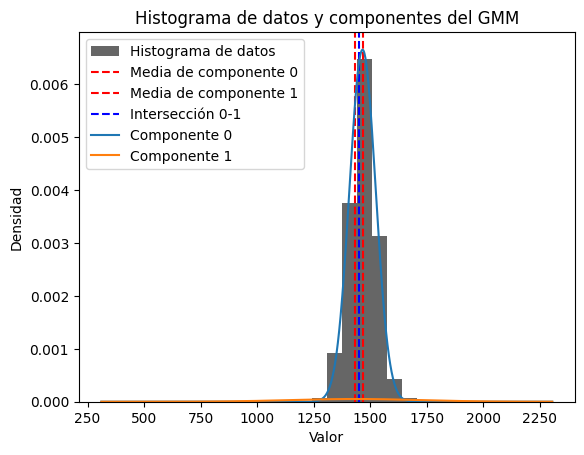

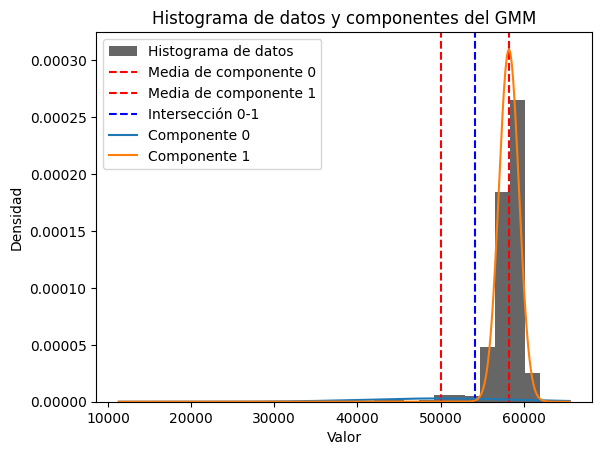

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=best_n_components, random_state=42)
gmm.fit(data)

gmm_color = GaussianMixture(n_components=best_gray_n_components, random_state=42)
gmm_color.fit(gray_data)

def plot_gmm(data, gmm, best_n_components):
    # Calcular el histograma de los datos
    plt.hist(data[:, 0], bins=30, density=True, alpha=0.6, color='k', label='Histograma de datos')

    # Generar datos sintéticos para cada componente del GMM
    x = np.linspace(min(data[:, 0]), max(data[:, 0]), 1000).reshape(-1, 1)
    logprob = gmm.score_samples(x)
    responsibilities = gmm.predict_proba(x)
    pdf = np.exp(logprob)
    pdf_individual = responsibilities * pdf[:, np.newaxis]

    # vline in the mean of each component
    for i in range(best_n_components):
        plt.axvline(gmm.means_[i], color='r', linestyle='--', label=f'Media de componente {i}')

    # vline in the intersection of the components
    for i in range(best_n_components - 1):
        plt.axvline((gmm.means_[i] + gmm.means_[i + 1]) / 2, color='b', linestyle='--', label=f'Intersección {i}-{i+1}')

    # Graficar las componentes del GMM
    for i in range(best_n_components):
        plt.plot(x, pdf_individual[:, i], label=f'Componente {i}')

    # Configurar el plot
    plt.title('Histograma de datos y componentes del GMM')
    plt.xlabel('Valor')
    plt.ylabel('Densidad')
    plt.legend()
    plt.show()

plot_gmm(data, gmm, best_n_components)
plot_gmm(gray_data, gmm_color, best_gray_n_components)

In [77]:
water_intensity_t = np.min(best_means)
other_points_intensity_t = np.max(best_means)

water_color_t = np.mean(best_gray_means)

#water_points = two_returns_1[two_returns_1[:,-3] < water_t]
#noise_water = two_returns_1[ (two_returns_1[:,-3] >= water_t) & (two_returns_1[:,-3] <= other_points_t)]
#pool_bottom = two_returns_1[two_returns_1[:,-3] > other_points_t]

water_points = two_returns_1[(two_returns_1[:,-3] < water_intensity_t) & (two_returns_1[:,7] > water_color_t)]
noise_water = two_returns_1[(two_returns_1[:,-3] >= water_intensity_t) & (two_returns_1[:,-3] <= other_points_intensity_t)]
pool_bottom = two_returns_1[(two_returns_1[:,-3] >= water_intensity_t)]

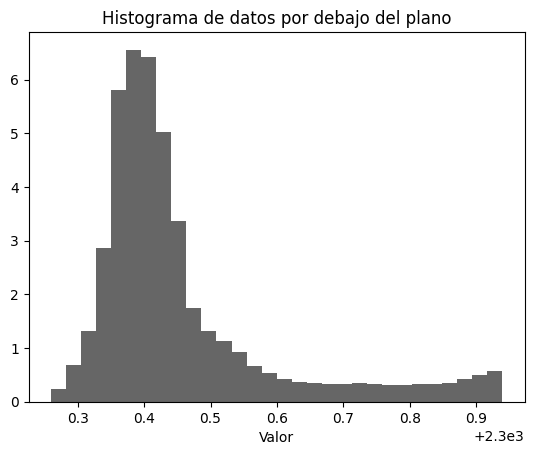

In [78]:
water_points_mask = (water_points[:, 5] >= np.mean(water_points[:, 5]) - 2 * np.std(water_points[:, 5])) & (water_points[:, 5] <= np.mean(water_points[:, 5]) + 2 * np.std(water_points[:, 5]))  # remove_low_density_points(water_points[:,:3], radius=0.3, min_neighbors=2)
water_points = water_points[water_points_mask]

other_points = np.vstack((one_return, two_returns_2, pool_bottom))
other_points_mask = remove_low_density_points(other_points[:,:3])
other_points = other_points[other_points_mask]

## ----- 
mean_of_water_points = np.mean(water_points[:,5], axis=0)

DELTA_WATER = mean_of_water_points * 0.1 #0.25 

distances = other_points[:, 5] - mean_of_water_points

# Separar los puntos por encima y por debajo del plano
below_plane = distances < -DELTA_WATER
above_plane = distances >= DELTA_WATER

other_points_below = other_points[below_plane]
other_points_above = other_points[above_plane]

other_points_below_z = other_points_below[:, 2]
plt.hist(other_points_below_z, bins=30, density=True, alpha=0.6, color='k', label='Histograma de datos')
plt.title('Histograma de datos por debajo del plano')
plt.xlabel('Valor')
plt.show()

In [79]:
other_points_below = other_points_below[other_points_below[:, 2] < np.mean(other_points_below[:, 2]) + np.std(other_points_below[:, 2])]

In [80]:
# plotter = pv.Plotter()

# water_points_pv = pv.PolyData(water_points[:,3:6])
# plotter.add_points(water_points_pv, color='blue', point_size=5)

# noise_water_pv = pv.PolyData(noise_water[:,3:6])
# plotter.add_points(noise_water_pv, color='red', point_size=5)

# points_1_pv = pv.PolyData(other_points[:,3:6])
# plotter.add_points(points_1_pv, color='green', point_size=5)

# points_pv = pv.PolyData(one_return[:,3:6])
# plotter.add_points(points_pv, color='yellow', point_size=5)

# plotter.show()

In [81]:
# Crear un plotter de PyVista
plotter = pv.Plotter()

water_points_pv = pv.PolyData(water_points[:,3:6])
plotter.add_points(water_points_pv, color='blue', point_size=5)


noise_pv = pv.PolyData(other_points_above[:,3:6])
plotter.add_points(noise_pv, color='red', point_size=5)

points_pv = pv.PolyData(other_points_below[:,3:6])
plotter.add_points(points_pv, color='green', point_size=5)

plotter.show()

Widget(value='<iframe src="http://localhost:43979/index.html?ui=P_0x7a9507f10800_12&reconnect=auto" class="pyv…

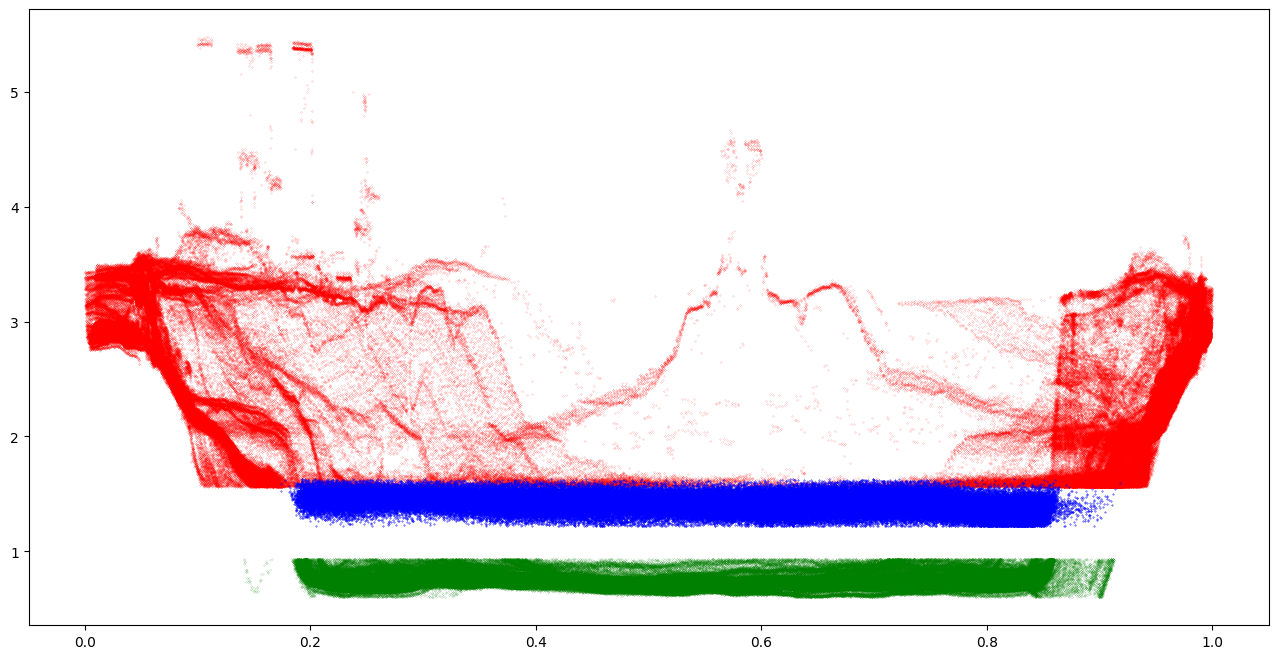

In [82]:
plt.figure(figsize=(16,8))
plt.scatter(other_points_above[:,3], other_points_above[:,5]*(z_max-z_min), c='red', s=0.01)
plt.scatter(other_points_below[:,3], other_points_below[:,5]*(z_max-z_min), c='green', s=0.01)
plt.scatter(water_points[:,3], water_points[:,5] *(z_max-z_min), c='blue', s=0.1)
plt.show()  

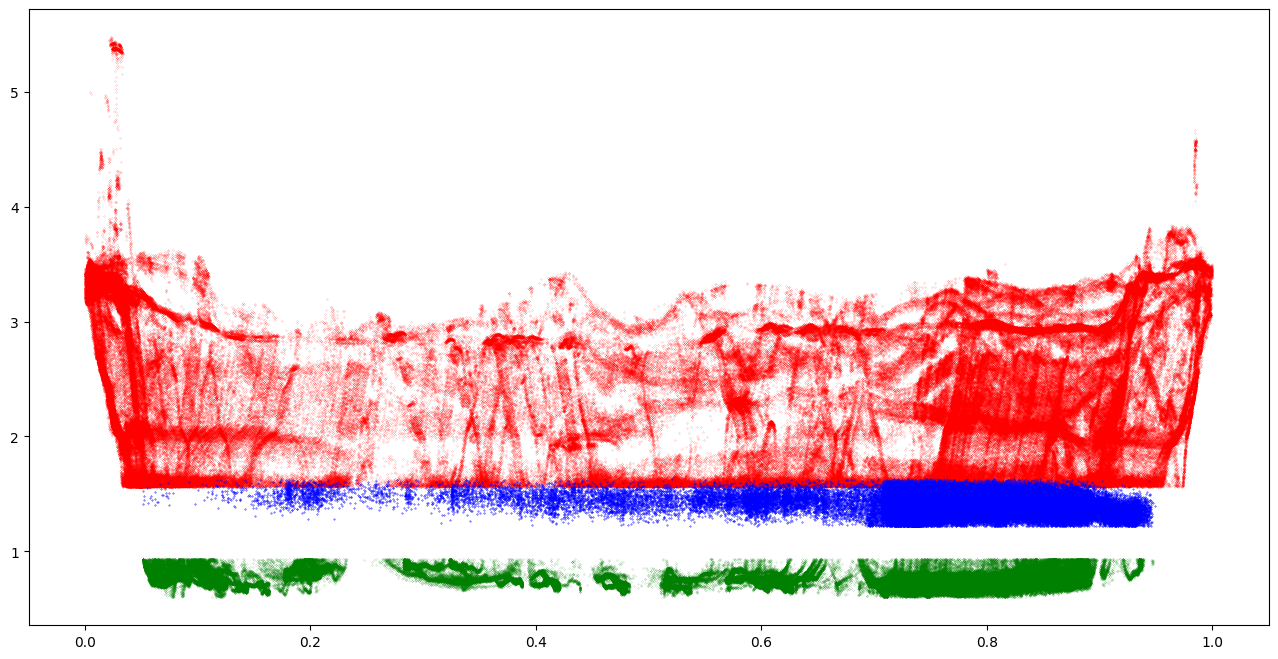

In [83]:
plt.figure(figsize=(16,8))
plt.scatter(other_points_above[:,4], other_points_above[:,5]*(z_max-z_min), c='red', s=0.01)
plt.scatter(other_points_below[:,4], other_points_below[:,5]*(z_max-z_min), c='green', s=0.01)
plt.scatter(water_points[:,4], water_points[:,5] *(z_max-z_min), c='blue', s=0.1)
plt.show()  

In [84]:
points_below = other_points_below[:,3:6]

# Calcular las diagonales principales y secundarias
x_min_below = np.min(points_below[:, 0])
x_max_below = np.max(points_below[:, 0])
y_min_below = np.min(points_below[:, 1])
y_max_below = np.max(points_below[:, 1])

# Diagonal principal (de (x_min, y_min) a (x_max, y_max))
diagonal1 = np.array([x_min_below, y_min_below, 0]), np.array([x_max_below, y_max_below, 0])

# Diagonal secundaria (de (x_min, y_max) a (x_max, y_min))
diagonal2 = np.array([x_min_below, y_max_below, 0]), np.array([x_max_below, y_min_below, 0])

# Función para calcular la distancia de un punto a una línea
def distance_to_line(points, line_start, line_end):
    x0, y0, z0 = points[:, 0], points[:, 1], points[:, 2]
    x1, y1, z1 = line_start
    x2, y2, z2 = line_end
    numerator = np.abs((y2 - y1) * x0 - (x2 - x1) * y0 + x2 * y1 - y2 * x1)
    denominator = np.sqrt((y2 - y1)**2 + (x2 - x1)**2)
    return numerator / denominator

# Umbral de distancia para considerar que un punto está en la diagonal
threshold = 0.01

# Identificar los puntos que pertenecen a las diagonales
distances_diagonal1 = distance_to_line(points_below, diagonal1[0], diagonal1[1])
distances_diagonal2 = distance_to_line(points_below, diagonal2[0], diagonal2[1])

points_on_diagonal1 = points_below[distances_diagonal1 < threshold]
points_on_diagonal2 = points_below[distances_diagonal2 < threshold]

mask_on_diagonal1 = remove_low_density_points(points_on_diagonal1, radius=threshold, min_neighbors=10)
mask_on_diagonal2 = remove_low_density_points(points_on_diagonal2, radius=threshold, min_neighbors=10)

points_on_diagonal1 = points_on_diagonal1[mask_on_diagonal1]
points_on_diagonal2 = points_on_diagonal2[mask_on_diagonal2]


# Crear un plotter de PyVista
plotter = pv.Plotter()

# Añadir los puntos por debajo del plano en verde
points_below_pv = pv.PolyData(points_below)
plotter.add_points(points_below_pv, color='green', point_size=5)

# Añadir los puntos en las diagonales en azul
points_on_diagonal1_pv = pv.PolyData(points_on_diagonal1)
points_on_diagonal2_pv = pv.PolyData(points_on_diagonal2)
plotter.add_points(points_on_diagonal1_pv, color='blue', point_size=10)
plotter.add_points(points_on_diagonal2_pv, color='red', point_size=10)

# Mostrar el plotter
plotter.show()

Widget(value='<iframe src="http://localhost:43979/index.html?ui=P_0x7a954a35d640_13&reconnect=auto" class="pyv…

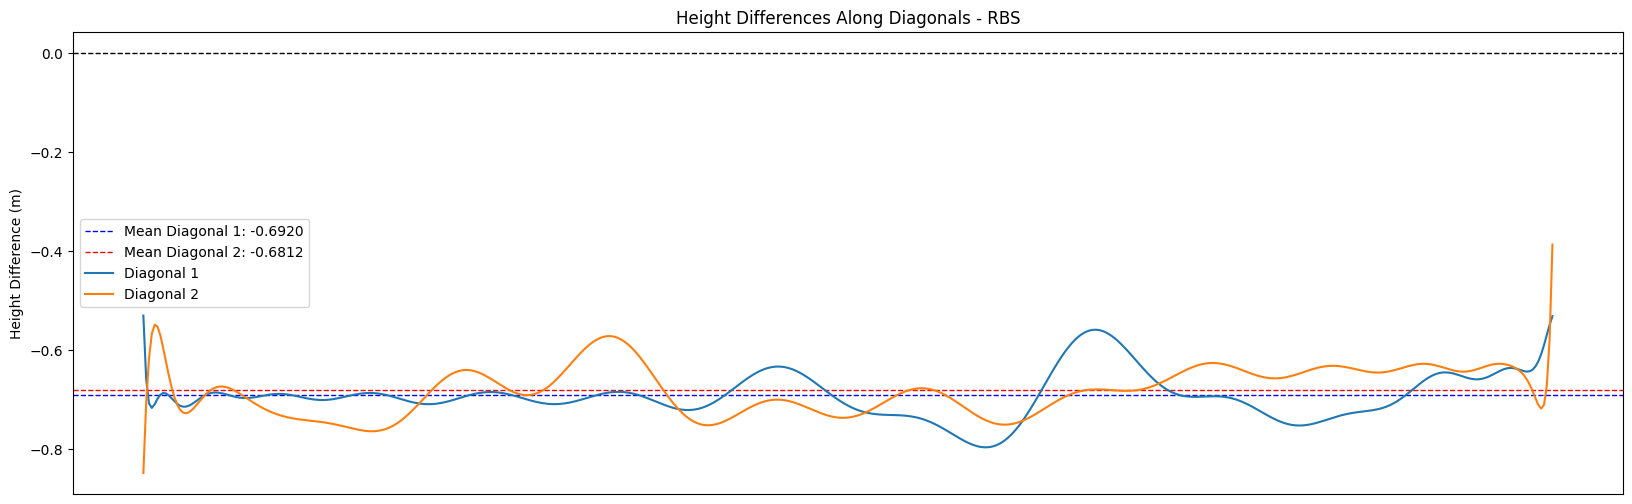

In [86]:
height_water = np.mean(water_points[:,5])

z_d1 = (height_water - points_on_diagonal1[:,2]) * (z_max - z_min) * -1
z_d2 = (height_water - points_on_diagonal2[:,2]) * (z_max - z_min) * -1
z_d2 = z_d2[::-1]

degree = 30  
poly_d1 = Polynomial.fit(np.arange(len(z_d1))/(len(z_d1)-1), z_d1, degree)
poly_d2 = Polynomial.fit(np.arange(len(z_d2))/(len(z_d2)-1), z_d2, degree)

x_new_d1 = np.linspace(0, 1, 500)
x_new_d2 = np.linspace(0, 1, 500)
z_new_d1 = poly_d1(x_new_d1)
z_new_d2 = poly_d2(x_new_d2)

mean_diagonal1 = np.mean(z_d1)
mean_diagonal2 = np.mean(z_d2)

plt.figure(figsize=(20, 6))
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.axhline(mean_diagonal1, color='blue', linestyle='--', linewidth=1, label=f'Mean Diagonal 1: {mean_diagonal1:.4f}')
plt.axhline(mean_diagonal2, color='red', linestyle='--', linewidth=1, label=f'Mean Diagonal 2: {mean_diagonal2:.4f}')
plt.plot(x_new_d1, z_new_d1, label='Diagonal 1')
plt.plot(x_new_d2, z_new_d2, label='Diagonal 2')
plt.ylabel('Height Difference (m)')
plt.title(f'Height Differences Along Diagonals - {POOL_NAME}')
plt.xticks([])
plt.legend()
plt.savefig(f'{OUTPUTS_PATH}/{POOL_NAME}_diagonals.png')
plt.show()

In [87]:
# plt.figure(figsize=(20, 6))
# plt.axhline(0, color='black', linestyle='--', linewidth=1)
# plt.axhline(mean_diagonal1, color='blue', linestyle='--', linewidth=1, label=f'Mean Diagonal 1: {mean_diagonal1:.4f}')
# plt.axhline(mean_diagonal2, color='red', linestyle='--', linewidth=1, label=f'Mean Diagonal 2: {mean_diagonal2:.4f}')
# plt.plot(np.arange(len(z_d1))/(len(z_d1)-1), z_d1, label='Diagonal 1')
# plt.plot(np.arange(len(z_d2))/(len(z_d2)-1), z_d2, label='Diagonal 2')
# plt.ylabel('Height Difference (m)')
# plt.title(f'Height Differences Along Diagonals - {POOL_NAME}')
# plt.xticks([])
# plt.legend()
# plt.savefig(f'{OUTPUTS_PATH}/{POOL_NAME}_diagonals.png')
# plt.show()

In [88]:
z_points = (height_water - points_below[:,2]) * (z_max - z_min) * -1 
depth_mean_pool = np.mean(z_points)
depth_mean_pool

np.float64(-0.6705669548657786)

In [89]:
import json

file = {
    "height_water_normalized": height_water,
    "depth_pool": {
        "mean" :depth_mean_pool,
        "unit": "[m]"
    },
    "denormalize" : {
        "x_min": x_min,
        "x_max": x_max,
        "y_min": y_min,
        "y_max": y_max,
        "z_min": z_min,
        "z_max": z_max
    },
    "diagonal1" : {
        "unit": "[m]",
        "mean": mean_diagonal1,
        "x_axis": x_new_d1.tolist(),
        "y_axis": z_new_d1.tolist(),
    },
    "diagonal2" : {
        "unit": "[m]",
        "mean": mean_diagonal2,
        "x_axis": x_new_d2.tolist(),
        "y_axis": z_new_d2.tolist(),
    }
}

#with open(f'{OUTPUTS_PATH}/{POOL_NAME}.json', 'w') as json_file:
#    json.dump(file, json_file, indent=4)

Grid Resolution: 1024 x 1187


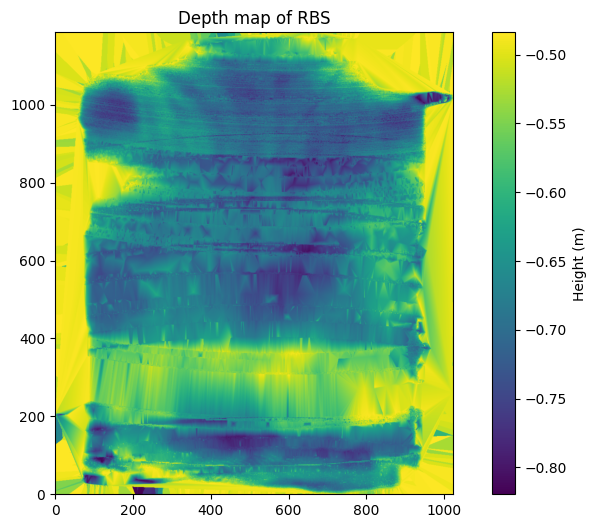

In [90]:
z = z_points 

x0, y0, z0 = water_points[:, 0], water_points[:, 1], water_points[:, 2]
x1, y1, z1 = points_below[:, 0], points_below[:, 1], points_below[:, 2]

grid_res_x = 1024  
x1_min, x1_max = x1.min(), x1.max()
y1_min, y1_max = y1.min(), y1.max()

grid_res_y = int(grid_res_x * (y1_max - y1_min) / (x1_max - x1_min))
print(f"Grid Resolution: {grid_res_x} x {grid_res_y}")

grid_x, grid_y = np.meshgrid(
    np.linspace(x1_min, x1_max, grid_res_x),
    np.linspace(y1_min, y1_max, grid_res_y)
)

# First interpolation using linear method
grid_z_linear = griddata((x1, y1), z, (grid_x, grid_y), method="linear") 

# Second interpolation using nearest method to ensure complete surface
grid_z_nearest = griddata((x1, y1), z, (grid_x, grid_y), method="nearest") 

# Combine the results to ensure complete surface
grid_z = np.where(np.isnan(grid_z_linear), grid_z_nearest, grid_z_linear)

# Plotting the combined result
plt.figure(figsize=(10, 6))
plt.imshow(grid_z, origin='lower', cmap='viridis')
plt.colorbar(label='Height (m)')
plt.title(f'Depth map of {POOL_NAME}')
plt.show()

In [47]:
os.environ["OPENCV_IO_ENABLE_OPENEXR"] = "1"

z_save = grid_z.astype(np.float32) 
#cv2.imwrite(f'{OUTPUTS_PATH}/{POOL_NAME}.exr', z_save)

pil_image_z = Image.fromarray(z_save)
pil_image_z.save(f'{OUTPUTS_PATH}/{POOL_NAME}.tiff')